<a href="https://colab.research.google.com/github/Justawayx/microbe_tracking/blob/master/RNN_centroids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My\ Drive/image_segmentation/RNN_centroids

/content/drive/.shortcut-targets-by-id/1oL1IKgNdUkjyUG9U8GsIIiZwuLk7-0r1/image_segmentation/RNN_centroids


In [ ]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from skimage import filters
from skimage.color import rgb2gray
import cv2
import glob


tf.compat.v1.disable_eager_execution()


def Distance_MSE(max_centroids):
    def loss(y_pred, y_true):
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids*2))
        y_pred = tf.keras.backend.repeat(y_pred, max_centroids)
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids, max_centroids, 2))
        y_pred2 = tf.keras.backend.permute_dimensions(y_pred, pattern=(0,2,1,3))

        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids*2))
        y_true = tf.keras.backend.repeat(y_true, max_centroids)
        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids, max_centroids, 2))
        y_true = tf.keras.backend.permute_dimensions(y_true, pattern=(0, 2, 1, 3))

        distance1 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_true),axis=3)
        distance2 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_pred2),axis=3)

        prob = tf.keras.activations.exponential(-1 * distance1/tf.keras.backend.sum(distance1))
        prob2 = tf.keras.backend.sum(tf.keras.activations.exponential(-1 * distance2),axis=1)

        return tf.reduce_mean(prob * distance1)
    return loss


def MSE_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.square(y_true - y_pred))


def abs_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.abs(y_true - y_pred))


def Modified_dice_loss():
    def loss(y_true, y_pred):
      y_pred = convert_to_logits(y_pred)
      loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, beta)

      # or reduce_sum and/or axis=-1
      return tf.reduce_mean(loss)

    return loss
    

def develop_features_v2(folder_path):
    img_dir = folder_path # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    for f1 in files:
        img = cv2.imread(f1)
        img_gray = rgb2gray(img) #convert to grayscale
        threshold_val = filters.threshold_otsu(img_gray) #threashold image
        threshold_img = img_gray < threshold_val
        data.append(threshold_img)
    # return np.array(data)
    arr_data = np.array(data)
    m, n, o = arr_data.shape
    return np.reshape(arr_data, (m,n,o,1))


def develop_labels(folder_path, max_centroids = 0):
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    padded_frames = list()
    for file in files:
        print(file)
        frame = list()
        with open(folder_path + '/' + file, 'r') as f:
            cur_max = 0
            for line in f:
                x, y = line.split()
                print(int(x),int(y))
                frame.append((int(x), int(y)))
                cur_max += 1

            frame = np.array(frame, 'uint16')
            frames.append(frame)
            max_centroids = max(cur_max, max_centroids)

    for frame in frames:
        frame = np.pad(frame, ((0, max_centroids - np.shape(frame)[0]), (0, 0)), constant_values=((0,0),(0,0)))
        padded_frames.append(frame)

    return np.array(padded_frames, dtype='uint16'), max_centroids


def code_block(filters, inputs):
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2())(inputs)
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2())(conv_layer)
    pool = tf.keras.layers.MaxPool2D((2,2))(conv_layer)

    return pool


def createModel(image_dim, max_centroids, verbose = False):
    #image portion
    inputs1 = tf.keras.layers.Input(shape=(image_dim[0], image_dim[1], 1), dtype='float32')
    block = code_block(16, inputs1)
    block = code_block(4, block)
    block = code_block(4, block)
    conv = tf.keras.layers.Conv2D(1, (3, 3), activation='relu',padding='same')(block)
    flatten = tf.keras.layers.Flatten()(conv)
    dense = tf.keras.layers.Dense(max_centroids * 2)(flatten)
    reshape = tf.keras.layers.Reshape((max_centroids, 2))(dense)

    model = tf.keras.Model(inputs=inputs1, outputs=[reshape])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=Distance_MSE(max_centroids), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    if verbose:
        model.summary()

    return model

max_centroids = 0
# features = develop_features_v2('newFrames')
# print(features.shape)
# labels, max_centroids = develop_labels('newCentroids', 128)
model = createModel((1024, 1024), max_centroids, True)
model.fit(x=features[1:,:,:],y=labels[1:,:],batch_size=4,epochs=20,validation_split=0.1)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 1024, 16)    160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1024, 1024, 16)    2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 4)       580       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 4)       148       
______________________________________________

NameError: ignored

[136 287] [40.441727 51.092804]
[667 381] [40.461502 48.517715]
[745 238] [39.3392  49.71456]
[756 347] [38.877678 49.22636 ]
[297 596] [38.77165  48.636223]
[466 390] [39.878944 49.017735]
[736 587] [38.44671 50.22966]
[223 939] [39.64662  49.864773]
[350 824] [37.88259 49.30099]
[215 279] [38.844727 48.46543 ]
[232 261] [38.030437 50.491127]
[0 0] [38.77151  48.868942]
[0 0] [38.470142 48.00382 ]
[0 0] [39.57091  48.775024]
[0 0] [39.129723 49.725693]
[0 0] [38.408287 48.261322]
[0 0] [39.45377  50.336796]
[0 0] [38.0929   49.320236]
[0 0] [40.6465   49.293205]
[0 0] [39.73127  48.782448]
[0 0] [38.509842 49.23909 ]
[0 0] [39.102955 49.18547 ]
[0 0] [38.925488 49.366188]
[0 0] [40.29751  48.455173]
[0 0] [39.698246 49.73023 ]
[0 0] [39.083195 48.666046]
[0 0] [37.90185 49.49684]
[0 0] [40.579784 49.025467]
[0 0] [40.56889  49.772766]
[0 0] [38.400703 49.365376]
[0 0] [39.33814 48.24136]
[0 0] [39.64749 49.44586]
[0 0] [38.673763 48.06554 ]
[0 0] [39.37988  48.652134]
[0 0] [38.48805 

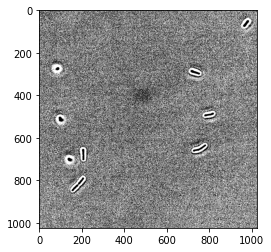

In [ ]:
from matplotlib import pyplot as plt

img = features[0,:,:,0]
pred = np.reshape((model.predict(img.reshape(1,1024,1024,1))), (128, 2))
for i in range(128):
    if pred[i,0] > 0 and pred[i, 0] < 1023 and pred[i,1] >= 1 and pred[i,1] < 1023:
        x = int(round(pred[i,0]))
        y = int(round(pred[i,1]))
        img[x,y] = 255
        img[x - 1, y] = 0
        img[x + 1, y] = 0
        img[x, y - 1] = 0
        img[x, y + 1] = 0

plt.imshow(img, cmap='gray')

for i in range(128):
    print(labels[0,i,:,], pred[i,:])

In [ ]:
model.predict(x=[features, START])

In [ ]:
# HARLAN: Attempting to fix loss function and other stuff



import numpy as np
import os
from PIL import Image
import tensorflow as tf
from skimage import filters
from skimage.color import rgb2gray
import cv2
import glob
import matplotlib.pyplot as plt


tf.compat.v1.disable_eager_execution()


def Distance_MSE(max_centroids):
    def loss(y_pred, y_true):
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids*2))
        y_pred = tf.keras.backend.repeat(y_pred, max_centroids)
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids, max_centroids, 2))
        y_pred2 = tf.keras.backend.permute_dimensions(y_pred, pattern=(0,2,1,3))

        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids*2))
        y_true = tf.keras.backend.repeat(y_true, max_centroids)
        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids, max_centroids, 2))
        y_true = tf.keras.backend.permute_dimensions(y_true, pattern=(0, 2, 1, 3))

        distance1 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_true),axis=3)
        distance2 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_pred2),axis=3)

        prob = tf.keras.activations.exponential(-1 * distance1/tf.keras.backend.sum(distance1))
        prob2 = tf.keras.backend.sum(tf.keras.activations.exponential(-1 * distance2),axis=1)

        return tf.reduce_mean(prob * distance1)
    return loss

def boolstr_to_floatstr(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v
        

def Distance_MSE_v2(max_centroids):
    def loss(y_pred, y_true):
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)

        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids*2))
        y_pred = tf.keras.backend.repeat(y_pred, max_centroids)
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids, max_centroids, 2))
        y_pred2 = tf.keras.backend.permute_dimensions(y_pred, pattern=(0,2,1,3))

        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids*2))
        y_true = tf.keras.backend.repeat(y_true, max_centroids)
        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids, max_centroids, 2))
        y_true = tf.keras.backend.permute_dimensions(y_true, pattern=(0, 2, 1, 3))

        distance1 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_true),axis=3)
        distance2 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_pred2),axis=3)

        prob = tf.keras.activations.exponential(-1 * distance1/tf.keras.backend.sum(distance1))
        prob2 = tf.keras.backend.sum(tf.keras.activations.exponential(-1 * distance2),axis=1)

        return floatMask * tf.reduce_mean(prob * distance1)
    return loss


def Distance_MSE_v2(max_centroids):
    def loss(y_pred, y_true):
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)
        y_pred = y_pred * floatMask

        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids*2))
        y_pred = tf.keras.backend.repeat(y_pred, max_centroids)
        y_pred = tf.keras.backend.reshape(y_pred, (-1, max_centroids, max_centroids, 2))
        y_pred2 = tf.keras.backend.permute_dimensions(y_pred, pattern=(0,2,1,3))

        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids*2))
        y_true = tf.keras.backend.repeat(y_true, max_centroids)
        y_true = tf.keras.backend.reshape(y_true, (-1, max_centroids, max_centroids, 2))
        y_true = tf.keras.backend.permute_dimensions(y_true, pattern=(0, 2, 1, 3))

        distance1 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_true),axis=3)
        distance2 = tf.keras.backend.sum(tf.keras.backend.square(y_pred - y_pred2),axis=3)

        prob = tf.keras.activations.exponential(-1 * distance1/tf.keras.backend.sum(distance1))
        prob2 = tf.keras.backend.sum(tf.keras.activations.exponential(-1 * distance2),axis=1)

        return tf.reduce_mean(prob * distance1)
    return loss

def Distance_MSE_v3(max_centroids):
    def euclidean_distance_loss(y_true, y_pred):
        # Masking extra fields
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)
        y_pred = y_pred * floatMask

        """
        Euclidean distance loss
        https://en.wikipedia.org/wiki/Euclidean_distance
        :param y_true: TensorFlow/Theano tensor
        :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
        :return: float
        """
        return tf.keras.backend.sqrt(tf.reduce_mean(tf.keras.backend.square(y_pred - y_true)))
    return euclidean_distance_loss 

import numpy as np
def min_dist_func_wrapper(nodes):
    def closest_node(node):
        # nodes = np.asarray(nodes)
        deltas = nodes - node
        min_dist = tf.keras.backend.argmin(deltas)
        return min_dist
    return closest_node

# def closest_node(node, nodes):
#     # nodes = np.asarray(nodes)
#     deltas = nodes - node
#     dist_2 = np.einsum('ij,ij->i', deltas, deltas)
#     return np.argmin(dist_2)


def Distance_MSE_v4(max_centroids):
    def euclidean_distance_loss(y_true, y_pred):
        diff = y_pred - y_true

        # Masking extra fields
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)
        y_pred = y_pred * floatMask

        """
        Euclidean distance loss
        https://en.wikipedia.org/wiki/Euclidean_distance
        :param y_true: TensorFlow/Theano tensor
        :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
        :return: float
        """
        return tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(diff), axis=-1))
    return euclidean_distance_loss 


def Distance_MSE_v5(max_centroids):
    def euclidean_distance_loss(y_true, y_pred):
        diff = y_pred - y_true

        min_dists = tf.vectorized_map(min_dist_func_wrapper(y_pred), y_true)
        

        # Masking extra fields
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)
        min_dists = tf.keras.backend.cast_to_floatx(min_dists) * floatMask

        """
        Euclidean distance loss
        https://en.wikipedia.org/wiki/Euclidean_distance
        :param y_true: TensorFlow/Theano tensor
        :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
        :return: float
        """
        return tf.keras.backend.sqrt(tf.keras.backend.square(tf.reduce_mean(min_dists)))
    return euclidean_distance_loss 




def softargmax(x, beta=1e10):
  x = tf.convert_to_tensor(x)
  x_range = tf.range(x.shape.as_list()[-1], dtype=x.dtype)
  return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=-1)

def min_dist_func_wrapper_v2(nodes):
    def closest_node_v2(node):
        # nodes = np.asarray(nodes)
        deltas = -1 * tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(nodes - node), axis=1))
        min_dist = -1 * softargmax(deltas)
        return min_dist
    return closest_node_v2

def Distance_MSE_v6(max_centroids):
    def euclidean_distance_loss(y_true, y_pred):
        diff = y_pred - y_true

        min_dists = tf.vectorized_map(min_dist_func_wrapper_v2(y_pred), y_true)

        # Masking extra fields
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)
        floatMask1d = tf.keras.backend.sum(floatMask, axis=1)
        min_dists = tf.keras.backend.cast_to_floatx(min_dists)
        min_dists = min_dists * floatMask1d

        """
        Euclidean distance loss
        https://en.wikipedia.org/wiki/Euclidean_distance
        :param y_true: TensorFlow/Theano tensor
        :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
        :return: float
        """
        return tf.keras.backend.sqrt(tf.keras.backend.square(tf.reduce_mean(min_dists)))
    return euclidean_distance_loss 



def softargmax_v7(x, beta=1e10):
  x = tf.convert_to_tensor(x)
  x_range = tf.range(x.shape.as_list()[-1], dtype=x.dtype)
  return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=-1)

def min_dist_func_wrapper_v7(nodes):
    def closest_node_v2(node):
        # nodes = np.asarray(nodes)
        deltas = -1.0 * tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(nodes - node), axis=1))
        min_dist_index = tf.cast(softargmax_v7(deltas), dtype='int32') #SOME REASON THERE IS ERROR WITH CASTING HERE
        min_dist = -1.0 * tf.gather(deltas, min_dist_index)
        # min_dist = -1.0 * deltas[min_dist_index]
        return min_dist
    return closest_node_v2

def Distance_MSE_v7(max_centroids):
    def euclidean_distance_loss_v7(y_true, y_pred):
        min_dists = tf.vectorized_map(min_dist_func_wrapper_v7(y_pred), y_true)

        # Masking extra fields
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)
        floatMask1d = tf.keras.backend.sum(floatMask, axis=1)
        min_dists = tf.keras.backend.cast_to_floatx(min_dists)
        min_dists = min_dists * floatMask1d

        """
        Euclidean distance loss
        https://en.wikipedia.org/wiki/Euclidean_distance
        :param y_true: TensorFlow/Theano tensor
        :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
        :return: float
        """
        return tf.keras.backend.sqrt(tf.keras.backend.square(tf.reduce_mean(min_dists)))
    return euclidean_distance_loss_v7




def calc_proximity_error(preds):
    def sum_dists_other_nodes(pred):
        deltas = preds - pred
        euclidean_dists = tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(deltas), axis=-1))
        inv_exponential_dist = tf.math.exp(-euclidean_dists / 10.0)
        return inv_exponential_dist
    return sum_dists_other_nodes

def Distance_MSE_v7_invProximity(max_centroids):
    def euclidean_distance_loss_v7(y_true, y_pred):
        min_dists = tf.vectorized_map(min_dist_func_wrapper_v7(y_pred), y_true)

        # Masking extra fields
        mask = tf.keras.backend.not_equal(y_true, 0)
        floatMask = tf.keras.backend.cast_to_floatx(mask)
        floatMask1d = tf.keras.backend.sum(floatMask, axis=1)
        min_dists = tf.keras.backend.cast_to_floatx(min_dists)
        min_dists = min_dists * floatMask1d

        """
        Euclidean distance loss
        https://en.wikipedia.org/wiki/Euclidean_distance
        :param y_true: TensorFlow/Theano tensor
        :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
        :return: float
        """
        meanMinDists = tf.reduce_mean(min_dists)
        proximityError = tf.vectorized_map(calc_proximity_error(y_pred), y_pred)
        return meanMinDists + proximityError
    return euclidean_distance_loss_v7




def MSE_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.square(y_true - y_pred))


def abs_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.keras.backend.abs(y_true - y_pred))


def Modified_dice_loss():
    def loss(y_true, y_pred):
      y_pred = convert_to_logits(y_pred)
      loss = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, beta)

      # or reduce_sum and/or axis=-1
      return tf.reduce_mean(loss)

    return loss


#GLOBAL VARIABLE to specify how many image iterations there are
num_img_iterations = 2

def develop_features_v3(folder_path, num_files):
    global num_image_iterations
    img_dir = folder_path # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    # data = np.zeros((num_files * 4 * 3, 1024, 1024, 1))
    data = np.zeros((num_files * num_img_iterations, 1024, 1024, 1))
    files = sorted(files)
    i = 0
    for f1 in files:
        img = cv2.imread(f1)
        img_gray = rgb2gray(img) #convert to grayscale
        threshold_img = filters.gaussian(img_gray)
        threshold_img = filters.laplace(threshold_img)
        threshold_val = filters.threshold_yen(img_gray) #threshold image
        threshold_img = img_gray < threshold_val
        threshold_img = filters.median(threshold_img)
        #more filters
        threshold_img = np.array(threshold_img, dtype='float32')
        # data[i,:,:,0] = threshold_img
        # i += 1
        #COMMENTING OUT RANDOM VARIATION FOR TESTING, ALSO THE CENTROIDS GET MOVED WHEN YOU ROTATE SO HAVE TO DEAL WITH THAT
        for j in range(num_img_iterations):
            threshold_img = threshold_img + np.reshape(np.random.normal(0,0.05,1024*1024),(1024,1024))
            data[i,:,:,0] = threshold_img
            i += 1
        #     threshold_img = np.flip(threshold_img, axis=0)
        #     data[i,:,:,0] = threshold_img
        #     i += 1
        #     threshold_img = np.flip(threshold_img, axis=1)
        #     data[i,:,:,0] = threshold_img
        #     i += 1
        #     threshold_img = np.flip(threshold_img, axis=0)
        #     data[i,:,:,0] = threshold_img
        #     i += 1
    # return np.array(data)
    return data


def develop_labels_v2(folder_path, max_centroids):
    global num_img_iterations
    files = sorted([f for f in os.listdir(folder_path)])
    frames = list()
    for file in files:
        for j in range(num_img_iterations):
            frame = [(0,0)] * max_centroids
            i = 0
            with open(folder_path + '/' + file, 'r') as f:
                for line in f:
                    x, y = line.split()
                    frame[i] = (int(x), int(y))
                    i += 1
            frames.append(frame)
    frames_arr = np.array(frames)
    return frames_arr

def code_block(filters, inputs):
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2())(inputs)
    conv_layer = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2())(conv_layer)
    pool = tf.keras.layers.MaxPool2D((2,2))(conv_layer)

    return pool


def createModel(image_dim, max_centroids, verbose = False):
    #image portion
    inputs1 = tf.keras.layers.Input(shape=(image_dim[0], image_dim[1], 1), dtype='float32')
    block = code_block(16, inputs1)
    block = code_block(4, block)
    block = code_block(4, block)
    conv = tf.keras.layers.Conv2D(1, (3, 3), activation='relu',padding='same')(block)
    flatten = tf.keras.layers.Flatten()(conv)
    dense = tf.keras.layers.Dense(max_centroids * 2)(flatten)
    reshape = tf.keras.layers.Reshape((max_centroids, 2))(dense)

    model = tf.keras.Model(inputs=inputs1, outputs=[reshape])
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=Distance_MSE_v7(max_centroids), metrics=[tf.keras.metrics.MeanAbsoluteError()])

    if verbose:
        model.summary()

    return model

# max_centroids = 0
# features = develop_features_v2('newFrames')
# print(features.shape)
# labels, max_centroids = develop_labels('newCentroids', 128)
# model = createModel((1024, 1024), max_centroids, True)
# model.fit(x=features[1:,:,:],y=labels[1:,:],batch_size=4,epochs=20,validation_split=0.1)

max_centroids = 64 * 2
num_frames = 201
features = develop_features_v3('/content/drive/My Drive/image_segmentation/RNN_centroids/newFrames', num_frames)
print(features.shape)
print(features.nbytes/(1024 * 1024 * 1024))
labels = develop_labels_v2('/content/drive/My Drive/image_segmentation/RNN_centroids/newCentroids', max_centroids)#[:,:,1:]
print(labels.shape)
print(labels.nbytes / (1024 * 1024 * 1024))



(402, 1024, 1024, 1)
3.140625
(402, 128, 2)
0.000766754150390625


In [ ]:
#runmodel

model = createModel((1024, 1024), max_centroids, True)
print("FEATURES AND LABESL: ",len(features), len(labels))
model.fit(x=features,y=labels,batch_size=1,epochs=15,validation_split=0.1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1024, 1024, 16)    160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1024, 1024, 16)    2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 4)       580       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 512, 512, 4)       148       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 4)       0   

(1024, 1024)


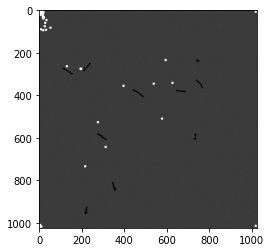

In [ ]:
# Visually inspect results

test_index = 0

img_ex = features[test_index,:,:,0]
centroids_ex = labels[test_index,:,:]

centroids_pred = model.predict(img_ex.reshape(1,1024,1024,1))
centroids_pred = centroids_pred.astype('int')
xs_pred, ys_pred = centroids_pred[0,:,0], centroids_pred[0,:,1]

img_ex_copy = np.empty_like(img_ex)
img_ex_copy[:] = img_ex

print(img_ex_copy.shape)

for i in range(0, 128):
  x = xs_pred[i]
  y = ys_pred[i]
  img_ex_copy[y-5:y+5,x-5:x+5] = 5

plt.imshow(img_ex_copy, cmap='gray')

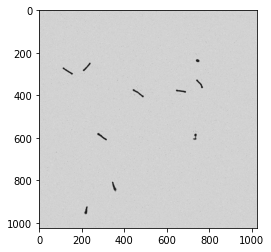

In [ ]:
#TESTING

plt.figure()
plt.imshow(features[0,:,:,0], cmap="gray")
plt.show()

In [ ]:
def calc_proximity_error(preds):
    def sum_dists_other_nodes(pred):
        deltas = preds - pred
        euclidean_dists = tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(deltas), axis=-1))
        print("eu dist: ", euclidean_dists )
        inv_exponential_dist = tf.math.exp(-euclidean_dists / 10.0)
        return inv_exponential_dist
    return sum_dists_other_nodes

nodes = tf.keras.backend.cast_to_floatx(tf.convert_to_tensor([(1,2),(4,4),(3,3)]))

min_dists = tf.vectorized_map(calc_proximity_error(nodes), nodes)
print("min dists: ", min_dists)

eu dist:  Tensor("loop_body_1/Sqrt:0", shape=(3,), dtype=float32)
min dists:  Tensor("loop_body_1/Exp/pfor/Exp:0", shape=(3, 3), dtype=float32)


In [ ]:


features_test = develop_features_v3('/content/drive/My Drive/cs168/test/Frames', num_frames)
print(features.shape)
labels_test = develop_labels_v2('/content/drive/My Drive/cs168/test/Centroids', max_centroids)#[:,:,1:]
print(labels.shape)

In [ ]:
model.evaluate(features_test, labels_test, verbose=1)